In [1]:
import pyprind
import pandas as pd
from string import punctuation
import re
import numpy as np

In [2]:
df = pd.read_csv('movie_data.csv',encoding='utf-8')

In [3]:
from collections import Counter
c = Counter()
c.update('abc')

In [4]:
c

Counter({'a': 1, 'b': 1, 'c': 1})

In [5]:
c['a']

1

In [6]:
c.update(['a','b'])

In [7]:
c

Counter({'a': 2, 'b': 2, 'c': 1})

In [8]:
c.update({'c':3})

In [9]:
c

Counter({'a': 2, 'b': 2, 'c': 4})

In [12]:
c.most_common(1)#가장 최빈 한 개 출력

[('c', 4)]

In [13]:
c.most_common()

[('c', 4), ('a', 2), ('b', 2)]

In [14]:
c.most_common(2)#최빈값 2개 출력

[('c', 4), ('a', 2)]

In [17]:
#데이터 전처리
#단어를 나누고 등장 횟수를 카운트함
from collections import Counter#원소를 카운트하여 딕셔너리에 저장
counts = Counter()
pbar = pyprind.ProgBar(len(df['review']),
                      title = '단어의 등장 횟수를 카운트합니다')

for i, review in enumerate(df['review']):
    text = ''.join([c if c not in punctuation else ' '+c+' '
                   for c in review] ).lower()
    df.loc[i, 'review'] = text
    pbar.update()
    counts.update(text.split())

단어의 등장 횟수를 카운트합니다
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:06:24


In [19]:
#고유한 각 단어를 정수로 매핑하는
#딕셔너리 생성
word_counts = sorted(counts, key=counts.get, reverse = True)
print(word_counts[:5])
word_to_int = {word:ii for ii,word in
              enumerate(word_counts,1)}#전체 리뷰 텍스트를 정수리스트로 변환

['the', '.', ',', 'and', 'a']


In [21]:
mapped_reviews = []
pbar = pyprind.ProgBar(len(df['review']),
                      title = '리뷰를 정수로 매핑합니다')
for review in df['review']:
    mapped_reviews.append([word_to_int[word]
                          for word in review.split()])
    pbar.update()

리뷰를 정수로 매핑합니다
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


In [22]:
#동일 길이의 시퀀스를 만듭니다
#시퀀스 길이가 200보다 작으면 왼쪽에 0이 패딩됩니다
#시퀀스 길이가 200보다 크면 마지막 200개 원소만 사용합니다(첫 원소들 잘림)
#데이터셋 전처리

sequence_length = 200#RNN 시퀀스 길이
sequences = np.zeros((len(mapped_reviews), sequence_length),
                    dtype=int)#0으로 채우기

for i, row in enumerate(mapped_reviews):
    review_arr = np.array(row)
    sequences[i, -len(row):] = review_arr[-sequence_length:]#동일한 길이의 시퀀스 만들기

In [23]:
#훈련 세트와 테스트 세트로 나눔
X_train = sequences[:37500,:]#75% 훈련세트
y_train = df.loc[:37499, 'sentiment'].values
X_test = sequences[37500:,:]#25% 테스트 세트
y_test = df.loc[37500:, 'sentiment'].values

In [24]:
#크기 확인
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(37500, 200) (37500,) (12500, 200) (12500,)


In [25]:
#딕셔너리 크기 확인
n_words = len(word_to_int)+1#딕셔너리 크기 확인
print(n_words)

102967


In [26]:
#임베딩: 데이터셋에 있는 필터를 표현하는데 중요한 특성을 자동으로 학습 가능
from tensorflow.keras import modelsls, layers
model = models.Sequential()

In [27]:
#임베딩층 추가
model.add(layers.Embedding(n_words, 200,#어휘 사전의 크기, 출력 차원
                          embeddings_regularizer = 'l2'))#L2 규제

In [29]:
#모델 구조 출력
model.summary()#임베딩의 출력은 3차원 텐서(배치 차원, 타임 스템, 임베딩 벡터의 차원)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 200)         20593400  
Total params: 20,593,400
Trainable params: 20,593,400
Non-trainable params: 0
_________________________________________________________________


In [30]:
#LSTM층 사용
model.add(layers.LSTM(16))#16개의 순환 유닛

In [31]:
model.add(layers.Flatten())#순환층을 추가한 후 출력층에 연결하기 위해 펼쳐야 함
model.add(layers.Dense(1, activation = 'sigmoid'))

In [32]:
model.summary()#전체 모델 구조 출력

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 200)         20593400  
_________________________________________________________________
lstm (LSTM)                  (None, 16)                13888     
_________________________________________________________________
flatten (Flatten)            (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 17        
Total params: 20,607,305
Trainable params: 20,607,305
Non-trainable params: 0
_________________________________________________________________


출력 크기: (None,16)<br>
첫번째 차원: 배치 차원, 두번째 차원: 셀의 출력(유닛 개수) 차원<br>

In [33]:
#Adam 옵티마이저를 사용하여 모델 컴파일
model.compile(loss = 'binary_crossentropy',#이진 분류 문제
             optimizer = 'adam', metrics = ['acc'])

In [51]:
#가장 좋은 검증 점수의 모델 파라미터를 체크포인트로 저장
#텐서 보드를 위한 출력 지정
import time
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard

callback_list = [ModelCheckpoint(filepath = 'sentiment_rnn_checkpoint.h5',
                                monitor = 'val_loss',
                                save_best_only=True),
                 
                TensorBoard(log_dir = 'sentiment_rnn_logs/{}'.format(str(time.asctime())[:5]))]

In [52]:
#모델 훈련
history = model.fit(X_train, y_train,
                   batch_size=64, epochs = 10,#배치크기 64로 지정, 열번 에포크 동안 훈련
                   validation_split=0.3, callbacks=callback_list)#전체 훈련 세트의 30%를 검증 세트로 사용

Epoch 1/10
411/411 [==============================] - 214s 503ms/step - loss: 6.5235 - acc: 0.7286 - val_loss: 0.6713 - val_acc: 0.7788
Epoch 2/10
411/411 [==============================] - 197s 480ms/step - loss: 0.6190 - acc: 0.8276 - val_loss: 0.5798 - val_acc: 0.8396
Epoch 3/10
411/411 [==============================] - 196s 477ms/step - loss: 0.5742 - acc: 0.8468 - val_loss: 0.5518 - val_acc: 0.8498
Epoch 4/10
411/411 [==============================] - 202s 491ms/step - loss: 0.5476 - acc: 0.8544 - val_loss: 0.5639 - val_acc: 0.8487
Epoch 5/10
411/411 [==============================] - 199s 485ms/step - loss: 0.5264 - acc: 0.8646 - val_loss: 0.5309 - val_acc: 0.8647
Epoch 6/10
411/411 [==============================] - 202s 492ms/step - loss: 0.5085 - acc: 0.8729 - val_loss: 0.4790 - val_acc: 0.8720
Epoch 7/10
411/411 [==============================] - 205s 500ms/step - loss: 0.4850 - acc: 0.8781 - val_loss: 0.4869 - val_acc: 0.8770
Epoch 8/10
411/411 [============================

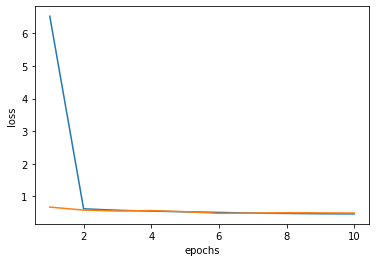

In [54]:
#손실 점수에 대한 그래프 그리기
import matplotlib.pyplot as plt
epochs = np.arange(1,11)
plt.plot(epochs, history.history['loss'])
plt.plot(epochs, history.history['val_loss'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

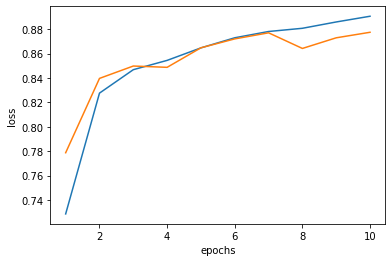

In [56]:
#정확도 그래프 그리기
epochs = np.arange(1,11)
plt.plot(epochs, history.history['acc'])
plt.plot(epochs, history.history['val_acc'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

In [57]:
#체크포인트 복원
model.load_weights('sentiment_rnn_checkpoint.h5')
#감성 분석 RNN 모델 평가
model.evaluate(X_test, y_test)

391/391 [==============================] - 39s 99ms/step - loss: 0.4850 - acc: 0.8686


[0.48500856757164, 0.8686400055885315]

In [58]:
#긍정 리뷰일 확률 반환
model.predict_proba(X_test[:10])

C:\Anaconda3\envs\dsfs\lib\site-packages\tensorflow\python\keras\engine\sequential.py:430: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


array([[0.01192534],
       [0.02059531],
       [0.00386864],
       [0.935076  ],
       [0.99180347],
       [0.9635012 ],
       [0.04769766],
       [0.8796698 ],
       [0.02382815],
       [0.8976263 ]], dtype=float32)

In [59]:
#이진 분류 결과 반환
model.predict_classes(X_test[:10])

C:\Anaconda3\envs\dsfs\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


array([[0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1]])

In [ ]:
#하이퍼 파라미터 튜닝(테스트 세트를 반복적으로 사용하면 안됨)

sequence_length_list = [50,100,250,300]
for value in sequence_length_list:
    sequence_length = value#RNN 시퀀스 길이
    sequences = np.zeros((len(mapped_reviews), sequence_length),
                        dtype=int)#0으로 채우기

    for i, row in enumerate(mapped_reviews):
        review_arr = np.array(row)
        sequences[i, -len(row):] = review_arr[-sequence_length:]#동일한 길이의 시퀀스 만들기
    
    #훈련 세트와 테스트 세트로 나눔
    X_train = sequences[:37500,:]#75% 훈련세트
    y_train = df.loc[:37499, 'sentiment'].values
    X_test = sequences[37500:,:]#25% 테스트 세트
    y_test = df.loc[37500:, 'sentiment'].values
    
    n_words = len(word_to_int)+1#딕셔너리 크기 확인
    
    #모델
    model = models.Sequential()
    #임베딩층 추가
    model.add(layers.Embedding(n_words, 200,#어휘 사전의 크기, 출력 차원
                              embeddings_regularizer = 'l2'))#L2 규제
    #LSTM층 사용
    model.add(layers.LSTM(16))#16개의 순환 유닛
    model.add(layers.Flatten())#순환층을 추가한 후 출력층에 연결하기 위해 펼쳐야 함
    model.add(layers.Dense(1, activation = 'sigmoid'))
    #Adam 옵티마이저를 사용하여 모델 컴파일
    model.compile(loss = 'binary_crossentropy',#이진 분류 문제
             optimizer = 'adam', metrics = ['acc'])
    #모델 훈련
    history = model.fit(X_train, y_train,
                       batch_size=64, epochs = 10,#배치크기 64로 지정, 열번 에포크 동안 훈련
                       validation_split=0.3)#전체 훈련 세트의 30%를 검증 세트로 사용

In [62]:
#글자 단위 언어 모델 구현
import numpy as np
#텍스트를 읽고 처리합니다
with open('pg2265.txt','r',encoding = 'utf-8') as f:
    text = f.read()

text = text[15858:]
chars = set(text)#텍스트에 있는 고유한 글자 집합
char2int = {ch:i for i, ch in enumerate(chars)}#글자와 정수를 매핑한 딕셔너리
int2char = dict(enumerate(chars))#정수와 고유한 글자를 매핑한 딕셔너리
#텍스트를 넘파이 배열로 변환
text_ints = np.array([char2int[ch] for ch in text], dtype = np.int32)

In [66]:
#텍스트 전체 길이
len(text)

162849

In [67]:
#고유한 글자 수
len(chars)

65

In [68]:
#동일한 구조의 입력(x)과 출력(y) 만들기
def reshape_data(sequence, batch_size, num_steps):
    mini_batch_length = batch_size*num_steps
    num_batches = int(len(sequence)/mini_batch_length)
    if num_batches*mini_batch_length +1 > len(sequence):
        num_batches = num_batches -1
    #전체 배치에 포함되지 않는 시퀀스 끝부분은 삭제함
    x = sequence[0:num_batches *mini_batch_length]
    y = sequence[1:num_batches*mini_batch_length+1]
    
    #x와 y를 시퀀스 배치의 리스트로 나눔
    x_batch_splits = np.split(x, batch_size)
    y_batch_splits = np.split(y, batch_size)
    
    #합쳐진 배치 크기는
    #batch_size x mini_batch_length가 됨
    x = np.stack(x_batch_splits)
    y = np.stack(y_batch_splits)
    
    return x,y

In [69]:
#시퀀스 길이를 10으로 가정하고 reshape_data 함수를 사용하여 배치크기 64에 맞게 데이터를 바꿈

#테스트
train_x, train_y = reshape_data(text_ints, 64, 10)#배치크기 64, 시퀀스 길이 10
print(train_x.shape)

(64, 2540)


In [70]:
print(train_x[0,:10])

[ 5 23 18 52  5 44 47 42 18 11]


In [71]:
print(train_y[0,:10])

[23 18 52  5 44 47 42 18 11 57]


In [73]:
print(''.join(int2char[i] for i in train_x[0,:10]))

The Traged


In [75]:
print(''.join(int2char[i] for i in train_y[0,:10]))

he Tragedi


In [77]:
#미니 배치 생성
def create_batch_generator(data_x, data_y, num_steps):#메모리 부족 해결
    batch_size, tot_batch_length = data_x.shape[0:2]
    num_batches = int(tot_batch_length/num_steps)
    for b in range(num_batches):
        yield(data_x[:,b*num_steps:(b+1)*num_steps],
             data_y[:,b*num_steps:(b+1)*num_steps])

In [79]:
#길이 100까지만 사용하여 배치데이터를 테스트로 만들어보기
#시퀀스 길이는 15로 설정

bgen = create_batch_generator(train_x[:,:100], train_y[:,:100], 15)

for x,y in bgen:
    print(x.shape, y.shape, end = '  ')
    print(''.join(int2char[i] for i in x[0,:]).replace('\n', '*'), '    ',
         ''.join(int2char[i] for i in y[0,:]).replace('\n','*'))
    #훈련 데이터와 타깃 데이터가 올바르게 추출됨을 알 수 있음

(64, 15) (64, 15)  The Tragedie of      he Tragedie of 
(64, 15) (64, 15)   Hamlet**Actus       Hamlet**Actus P
(64, 15) (64, 15)  Primus. Scoena       rimus. Scoena P
(64, 15) (64, 15)  Prima.**Enter B      rima.**Enter Ba
(64, 15) (64, 15)  arnardo and Fra      rnardo and Fran
(64, 15) (64, 15)  ncisco two Cent      cisco two Centi


In [84]:
batch_size = 64#배치 크기

In [85]:
num_steps = 100#타임 스텝 길이

In [82]:
train_x, train_y = reshape_data(text_ints, batch_size, num_steps)

In [83]:
print(train_x.shape, train_y.shape)

(64, 2500) (64, 2500)


In [86]:
#원-핫 인코딩
from tensorflow.keras.utils import to_categorical
train_encoded_x = to_categorical(train_x)
train_encoded_y = to_categorical(train_y)
print(train_encoded_x.shape, train_encoded_y.shape)

(64, 2500, 65) (64, 2500, 65)


In [87]:
#한 글자만 이동했기에 train_x와 train_y의 최대값이 같아야 함
print(np.max(train_x),np.max(train_y))

64 64


In [88]:
#Sequential 클래스를 사용하여 글자 단위 RNN 모델 만들기
char_model = models.Sequential()

In [89]:
num_classes = len(chars)

In [91]:
char_model.add(layers.LSTM(128, input_shape = (None, num_classes), 
                          return_sequences = True))#128개의 순환 유닛을 가진 LSTM 층을 모델에 추가

In [93]:
char_model.add(layers.TimeDistributed(layers.Dense(num_classes,#TimeDistributed를 통해 Dense 층을 감싸서 
                                                   #타임 스탭을 가진 입력을 다룰 수 있음
                                                  activation = 'softmax')))#다중 출력이기에 활성화함수는 소프트맥스 함수를 사용

In [95]:
char_model.summary()#모델 구성

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, None, 128)         99328     
_________________________________________________________________
lstm_2 (LSTM)                (None, None, 128)         131584    
_________________________________________________________________
time_distributed (TimeDistri (None, None, 65)          8385      
_________________________________________________________________
time_distributed_1 (TimeDist (None, None, 65)          4290      
Total params: 243,587
Trainable params: 243,587
Non-trainable params: 0
_________________________________________________________________


In [98]:
#글자 단위 RNN 모델 훈련
from tensorflow.keras.optimizers import Adam#Adam 옵티마이저 사용
adam = Adam(clipnorm = 5.0)#L2노름의 임계 값: 5.0

In [100]:
char_model.compile(loss = 'categorical_crossentropy',optimizer = adam)#모델 컴파일

In [101]:
callback_list = [ModelCheckpoint(filepath = 'char_rnn_checkpoint.h5')]

In [102]:
for i in range(500):#500번의 에포크 동안 훈련
    bgen = create_batch_generator(train_encoded_x,
                                 train_encoded_y, num_steps)
    char_model.fit_generator(bgen, steps_per_epoch=25, epochs=1,
                            callbacks= callback_list, verbose = 0)#훈련과정 출력 x

C:\Anaconda3\envs\dsfs\lib\site-packages\tensorflow\python\keras\engine\training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


In [103]:
#모델이서 출력된 65객의 확률 값에서 하나를 랜덤하게 선택할 get_top_char 함수를 정의
np.random.seed(42)

def get_top_char(probas, char_size, top_n=5):
    p = np.squeeze(probas)
    p[np.argsort(p)[:-top_n]] = 0.0
    p = p/np.sum(p)
    ch_id = np.random.choice(char_size,1,p=p)[0]
    return ch_id

In [107]:
#"The "란 초기 문자열을 사용하여 이어지는 텍스트를 생성
seed_text = "The "
for ch in seed_text:
    num = [char2int[ch]]#한 글자씩 주입->마지막 글자에서 다음 글자를 예측
    onehot = to_categorical(num, num_classes = 65)#원-핫 인코딩 될 벡터 크기 지정
    onehot = np.expand_dims(onehot, axis = 0)#배치 차원을 만들기 위해 첫번째 차원 추가
    probas = char_model.predict(onehot)

In [108]:
num = get_top_char(probas, len(chars))
seed_text += int2char[num]

In [109]:
for i in range(500):#500번 되풀이 하여 긴 텍스트 만들기
    onehot = to_categorical([num], num_classes = 65)
    onehot = np.expand_dims(onehot, axis=0)
    probas = char_model.predict(onehot)
    num = get_top_char(probas, len(chars))
    seed_text += int2char[num]

In [110]:
print(seed_text)

The t iteee tnei seeonth hooo s te hei ihe te h s s tein w weeeoos sone hinhe innere theos t te it ttteee s woo seoei t ih t woeer we theo s ihi s soe teo se wo ih s tte see ie s h t hrei s itthe w so w inee tee he inh so t tnerso t t tnte se hi wreit w sr se w te we w inho i w t tnn sre h th he se ih he tnn th sreei iheeonnnhintnthr heee ite teronner t tee h w tntn t weeeee ho h se t i se i th si t ie t s te ho w tthr inne h t see tee h ieeihr winhe tt h h hee it th sieie t h w tntnt ho wr se s hi i


더 나은 결과를 얻으려면 에포크 수를 늘려서 모델 훈련해야 함